In [16]:
import torch
import numpy as np

from torch import nn

from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim

from einops import rearrange
from tqdm import tqdm

from dataclasses import dataclass
from generate_mass_spring_data import generate_mass_spring_data
from loss import compute_mmd

from matplotlib import pyplot as plt

from generate_3d_sho import generate_3d_sho

from sklearn.feature_selection import mutual_info_regression

In [17]:
@dataclass
class TrainConfig:
    num_epochs: int
    batch_size: int
    learning_rate: float
    device: str
    model: torch.nn.Module
    optimizer: optim.Optimizer 
    train_loader: DataLoader
    val_loader: DataLoader

In [18]:
def get_data_loaders(n_points: int, arr_size: int, batch_size: int = 32):
    # set torch seed
    torch.manual_seed(0)
    samples = torch.zeros((arr_size, n_points, 3, 2))
    for i in range(arr_size):
        low = 1
        high = 10
        m, k = 1, torch.ones((3,1))
        v0, x0 =  torch.randint(low, high, (2,3))
        samples[i] = rearrange(torch.stack(generate_3d_sho(k, m, v0, x0, 0.1, n_points)), ' c b d -> b d c')
    dataset = TensorDataset(samples)
    train_ds, val_ds = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))])
    return DataLoader(train_ds, batch_size=batch_size), DataLoader(val_ds, batch_size=batch_size)

In [19]:
train_dl, val_dl = get_data_loaders(100, 1000)

In [20]:
for i, data in enumerate(train_dl):
    print(data[0].shape)
    break

torch.Size([32, 100, 3, 2])


In [21]:
def train(config: TrainConfig):
    
    model.to(config.device)
    
    losses = []
    conservation_losses = []
    reconstruction_losses = []
    pbar = tqdm(range(config.num_epochs))
    for epoch in pbar:
        ep_losses = []
        ep_conservation_losses = []
        ep_reconstruction_losses = []
        config.model.train()

        for i, data in enumerate(config.train_loader):
            orig_data = data[0].to(config.device)
            b = orig_data.shape[0]
            c = orig_data.shape[2]
            formatted_data = rearrange(data[0], 'b s c d -> (b s) (c d)')
            data = formatted_data.to(config.device)
            encoder, decoder = config.model
            z = encoder(data)
            yhat = decoder(z)
            z_rearr = rearrange(z, '(b s) c -> b s c', b=b)
            z_0 = z_rearr[:, 0, :]
            # calculate the difference between z at each time step and z at time step 0
            z_diff = z_rearr - z_0[:, None, :]
            # calculate the conservation loss as mse
            conservation_loss = torch.mean(z_diff**2)
            
            #variance reconstruction loss
            yhat_rearr = rearrange(yhat, '(b s) (c d) -> b s c d', b=b, c=c)
            yhat_std = yhat_rearr.std(dim=1)
            data_std = orig_data.std(dim=1)
         
            #if i % 100 == 0:
            #    print(data_std[0], yhat_std[0])
            reconstruction_loss = torch.mean((yhat_std - data_std)**2)
            #reconstruction_loss = torch.mean((yhat - orig_data)**2)

            loss = reconstruction_loss + conservation_loss
            config.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            ep_losses.append(loss.clone().item())
            ep_conservation_losses.append(conservation_loss.clone().item())
            ep_reconstruction_losses.append(reconstruction_loss.clone().item())
            config.optimizer.step()
        config.model.eval()
        losses.append(np.mean(ep_losses))
        conservation_losses.append(np.mean(ep_conservation_losses))
        reconstruction_losses.append(np.mean(ep_reconstruction_losses))
        # update progress bar
        pbar.set_postfix({'loss': losses[-1], 'conservation_loss': conservation_losses[-1], 'reconstruction_loss': reconstruction_losses[-1]})
    return config.model, losses, conservation_losses, reconstruction_losses

In [22]:
encoder = nn.Sequential(
    nn.Linear(6, 20),
    nn.Sigmoid(),
    nn.Linear(20, 12),
    nn.Sigmoid(),
    nn.Linear(12, 2)
)

decoder = nn.Sequential(
    nn.Linear(2, 6),
    nn.ReLU(),
    nn.Linear(6, 6),
    nn.ReLU(),
    nn.Linear(6, 6)
)

model = nn.Sequential(encoder, decoder)

train_loader, val_loader = get_data_loaders(1000, arr_size=100, batch_size=32)

config = TrainConfig(
    num_epochs=5000,
    batch_size=32,
    learning_rate=0.001,
    device='cuda',
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5),
    train_loader=train_loader,
    val_loader=val_loader,
)

In [23]:
model, loss, conservation_loss, reconstruction_loss = train(config)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
def evaluate_model(model, data_loader, config):
    
    model = model.eval()
    model.to(config.device)
    losses = []
    conservation_losses = []
    reconstruction_losses = []
    
    for i, data in enumerate(data_loader):
        orig_data = data[0].to(config.device)
        b = orig_data.shape[0]
        c = orig_data.shape[2]
        
        formatted_data = rearrange(data[0], 'b s c d -> (b s) (c d)')
        data = formatted_data.to(config.device)
        encoder, decoder = model
        
        z = encoder(data)
        yhat = decoder(z)
        z_rearr = rearrange(z, '(b s) c -> b s c', b=b)
        z_0 = z_rearr[:, 0, :]
        # calculate the difference between z at each time step and z at time step 0
        z_diff = z_rearr - z_0[:, None, :]
        # calculate the conservation loss as mse
        conservation_loss = torch.mean(z_diff**2)
        
        #variance reconstruction loss
        yhat_rearr = rearrange(yhat, '(b s) (c d) -> b s c d', b=b, c=c)
        yhat_std = yhat_rearr.std(dim=1)
        data_std = orig_data.std(dim=1)
     
        #if i % 100 == 0:
        #    print(data_std[0], yhat_std[0])
        reconstruction_loss = torch.mean((yhat_std - data_std)**2)
        #reconstruction_loss = torch.mean((yhat - orig_data)**2)

        loss = reconstruction_loss + 0.2 * conservation_loss
        losses.append(loss.clone().item())
        conservation_losses.append(conservation_loss.clone().item())
        reconstruction_losses.append(reconstruction_loss.clone().item())
    return np.mean(losses), np.mean(conservation_losses), np.mean(reconstruction_losses)

In [ ]:
test_loss, test_conservation_loss, test_reconstruction_loss = evaluate_model(model, val_loader, config)

In [ ]:
print(test_loss, test_conservation_loss, test_reconstruction_loss)

0.040170155465602875 0.006080798339098692 0.038953997194767


In [ ]:
total_losses, conservation_losses, reconstruction_losses = [], [], []
for i in range(1,6):
    encoder = nn.Sequential(
        nn.Linear(6, 20),
        nn.Sigmoid(),
        nn.Linear(20, 12),
        nn.Sigmoid(),
        nn.Linear(12, i)
    )
    
    decoder = nn.Sequential(
        nn.Linear(i, 12),
        nn.ReLU(),
        nn.Linear(12, 12),
        nn.ReLU(),
        nn.Linear(12, 6)
    )
    model = nn.Sequential(encoder, decoder)
    config = TrainConfig(
        num_epochs=5000,
        batch_size=32,
        learning_rate=0.001,
        device='cuda',
        model=model,
        optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5),
        train_loader=train_loader,
        val_loader=val_loader,
    )
    model, loss, conservation_loss, reconstruction_loss = train(config)
    test_loss, test_conservation_loss, test_reconstruction_loss = evaluate_model(model, val_loader, config)
    total_losses.append(test_loss)
    conservation_losses.append(test_conservation_loss)
    reconstruction_losses.append(test_reconstruction_loss)

100%|██████████| 5000/5000 [00:36<00:00, 136.16it/s, loss=0.0105, conservation_loss=0.00314, reconstruction_loss=0.00737] 


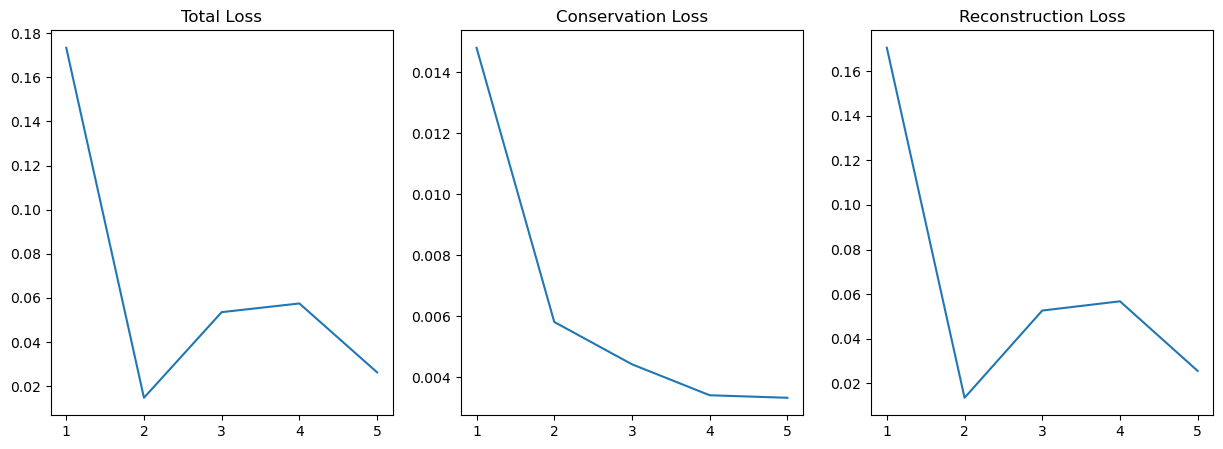

In [ ]:
latent_dims = range(1,6)
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(latent_dims, total_losses)
ax[0].set_title('Total Loss')
ax[1].plot(latent_dims, conservation_losses)
ax[1].set_title('Conservation Loss')
ax[2].plot(latent_dims, reconstruction_losses)
ax[2].set_title('Reconstruction Loss')
plt.show()

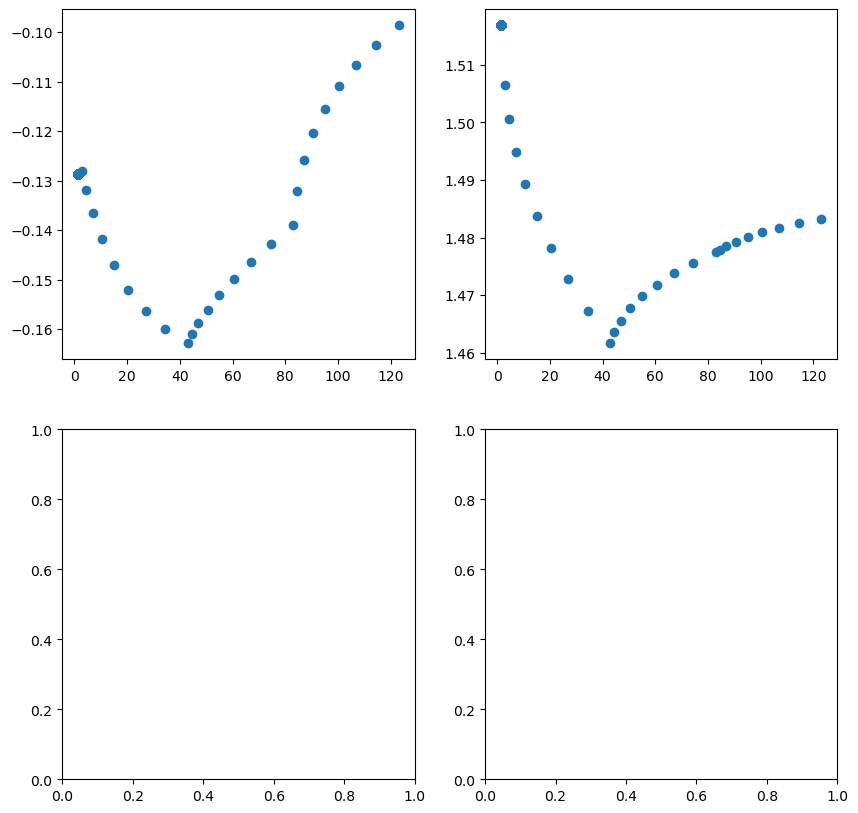

In [ ]:
model = model.eval()
x_test = torch.ones((1000,3))
y_test = torch.zeros((1000,3))
for i in range(1,10):
    for j in range(1,10):
        for k in range(1,10):
            y_test[i+j+k] = torch.tensor([i,j,k])
test = rearrange(torch.stack((x_test, y_test)), 'c b a -> b (c a)').to(config.device)
zs = model[0](test).cpu()
energy = 0.5 * torch.sum(y_test**2, dim=1) + 0.5 * torch.sum(x_test**2, dim=1)
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].scatter(energy, zs[:,0].detach().numpy(), label='z1')
ax[0,1].scatter(energy, zs[:,1].detach().numpy(), label='z2')
#ax[1,0].scatter(energy, zs[:,2].detach().numpy(), label='z3')
#ax[1,1].scatter(energy, zs[:,3].detach().numpy(), label='z4')
plt.show()




In [ ]:
import scipy.constants as const

In [ ]:
(8 * np.pi **  6 * (4.803e-10) ** 4 * 9.11e-28) / ((1.0546e-27) ** 2)

3.3526051877402376e-07

In [ ]:
#Evaluate Mutual Info in 3-D Case
model = model.eval()
x_test = torch.ones((100,1))
v_test = rearrange(torch.linspace(4, 10, 100), 'b -> b 1')
energy = 0.5 * v_test**2 + 0.5 * x_test**2
test = rearrange(torch.stack((x_test, v_test)), 'c b a -> b (c a)')
zs = model[0](test)


mutual_info_regression(energy.detach().numpy(),zs.detach().numpy())